In [62]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

In [63]:
# Parameters Setting
N = 100  # total number of agents
p = 0.03  # probability of connection
q = 0.38  # probability of innovation
proportion_innovators = 0.02  # proportion of innovators
proportion_influencers = 0.1  # proportion of influencers
steps = 100  # number of steps

In [64]:
class ConsumerAgent(Agent):
    def __init__(self, unique_id, model, agent_type, influencer):
        super().__init__(unique_id, model)
        self.adopted = False
        self.agent_type = agent_type  # 'Innovator' or 'Imitator'
        self.influencer = influencer  # influencer or not

    def step(self):
        if not self.adopted:
            if self.agent_type == 'Innovator':
                # innovators adopt the product with probability p
                if random.random() < self.model.p:
                    self.adopted = True
            elif self.agent_type == 'Imitator':
                # immiators adopt the product with probability q
                neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
                adopted_neighbors = [neighbor for neighbor in neighbors if neighbor.adopted]
                if random.random() < self.model.q * len(adopted_neighbors) / len(neighbors):
                    self.adopted = True

In [65]:
class BassModel(Model):
    def __init__(self, N, p, q, proportion_innovators, proportion_influencers, network_type="random"):
        # invoke the parent class's __init__ method
        super().__init__()
        self.num_agents = N
        self.p = p
        self.q = q
        self.schedule = RandomActivation(self)

        # create a network
        if network_type == "random":
            self.G = nx.erdos_renyi_graph(n=N, p=0.05)
        elif network_type == "small_world":
            self.G = nx.watts_strogatz_graph(n=N, k=4, p=0.1)

        # create agents and set their types and influence
        self.custom_agents = []  # store the agents with custom methods
        for i, node in enumerate(self.G.nodes()):
            agent_type = 'Innovator' if random.random() < proportion_innovators else 'Imitator'
            influencer = random.random() < proportion_influencers
            agent = ConsumerAgent(i, self, agent_type, influencer)
            self.schedule.add(agent)
            self.custom_agents.append(agent)

        # initialize NetworkGrid and place agents
        self.grid = NetworkGrid(self.G)
        for i, node in enumerate(self.G.nodes()):
            self.grid.place_agent(self.custom_agents[i], node)

        # add additional edges for influencers
        for agent in self.custom_agents:
            if agent.influencer:
                additional_edges = random.sample(
                    list(self.G.nodes()), 5)  # 增加5个邻居
                for target in additional_edges:
                    if not self.G.has_edge(agent.pos, target):
                        self.G.add_edge(agent.pos, target)

        self.datacollector = DataCollector(
            agent_reporters={"Adopted": "adopted"},
            model_reporters={"Adopted_Count": self.compute_adopted}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def compute_adopted(self):
        adopted_count = sum(
            [1 for agent in self.custom_agents if agent.adopted])
        return adopted_count

    def plot_network(self):
        pos = nx.spring_layout(self.G)
        adopted = [agent.adopted for agent in self.custom_agents]
        colors = ["red" if status else "blue" for status in adopted]
        influencer_sizes = [
            200 if agent.influencer else 50 for agent in self.custom_agents]

        nx.draw(self.G, pos, node_color=colors,
                with_labels=True, node_size=influencer_sizes)
        plt.show()

In [70]:
# create and run the model
model = BassModel(N, p, q, proportion_innovators,
                  proportion_influencers, network_type="random")
for _ in range(steps):
    model.step()

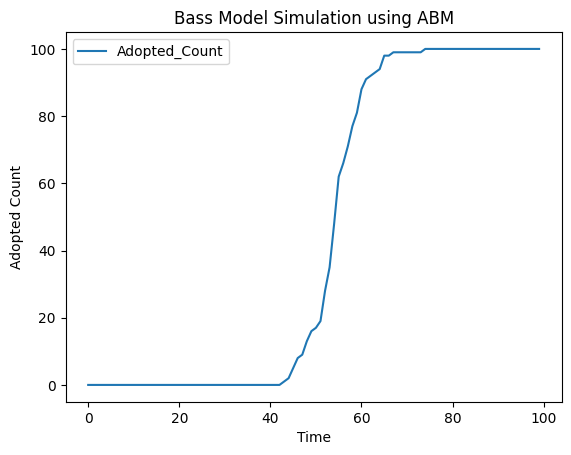

In [71]:
# data collection and visualization
results = model.datacollector.get_model_vars_dataframe()
results.plot()
plt.title("Bass Model Simulation using ABM")
plt.xlabel("Time")
plt.ylabel("Adopted Count")
plt.show()

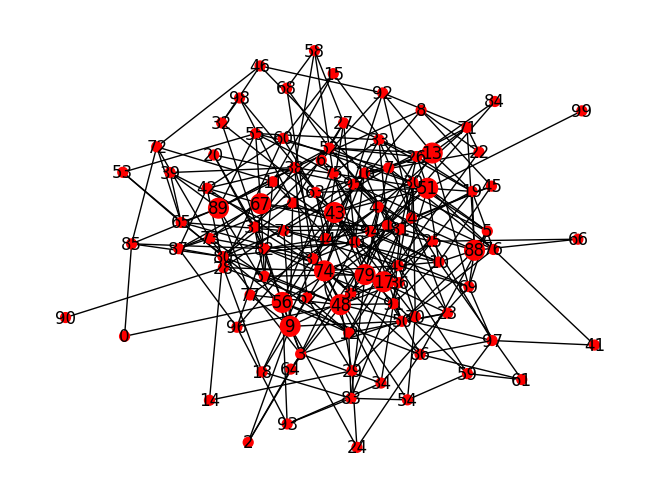

In [72]:
# plot the network
model.plot_network()